In [1]:
import torchaudio
import random
import torch
import pandas as pd
import os
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
labels_file = pd.read_csv('./data/labeled_ADSMI/labels_int.csv', index_col=0)
labels_file

,filename,Label_int,Label,fold
0,2014-06-17_09-20-53_01.WAV,0,[Kreischen],4
1,2014-05-27_16-38-25_01.WAV,0,[Kreischen],4
2,2014-07-10_06-30-19_01.WAV,0,[Kreischen],5
3,2014-07-02_11-20-06_01.WAV,0,[Kreischen],2
4,2014-07-18_18-04-16_01.WAV,2,[Negativ],2
...,...,...,...,...
4715,2014-06-18_03-16-04_01.WAV,0,[Kreischen],8
4716,2014-06-20_21-36-02_01.WAV,0,[Kreischen],5
4717,2014-09-19_02-16-42_01.WAV,1,[Kreischen][Quietschen],7
4718,2014-07-01_09-35-19_01.WAV,2,[Negativ],4


In [3]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def random_crop_or_pad(waveform, sample_rate, desired_length_in_seconds=5):
    """
    Randomly crops the waveform to the desired length in seconds.
    If the waveform is shorter than the desired length, it will be padded with zeros.
    """
    desired_length = desired_length_in_seconds * sample_rate
    current_length = waveform.shape[1]

    # If the waveform is shorter than desired, pad it with zeros
    if current_length < desired_length:
        padding_needed = desired_length - current_length
        left_pad = padding_needed // 2
        right_pad = padding_needed - left_pad
        waveform = torch.nn.functional.pad(waveform, (left_pad, right_pad))
    # Calculate the starting point for cropping
    start_idx = random.randint(0, waveform.shape[1] - desired_length)
    return waveform[:, start_idx:start_idx+desired_length]

# Load your audio data
path = './data/labeled_ADSMI/labeled_data_2013-535/'
file_n = os.listdir(path)
waveform, sample_rate = torchaudio.load(path + file_n[random.randint(0, len(file_n))])
waveform = waveform.to(device, dtype=torch.float32)  # Move waveform to GPU if available

cropped_waveform = random_crop_or_pad(waveform, sample_rate, desired_length_in_seconds=15).to(device)

In [4]:
# Define the transformation parameters
n_fft = 2048
hop_length = 512
n_mels = 80
win_length = 2048
window = 'hann'



mel_spectrogram = T.MelSpectrogram(
    sample_rate=32000,  # Your sample rate
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels,
    win_length=win_length,
    window_fn=torch.hann_window  # This corresponds to the 'hann' window
).to(device)


 # Instantiate the transform and move it to the same device as the waveform
melspe = mel_spectrogram(cropped_waveform)  # Apply the transform on the waveform

In [5]:
# Convert amplitude to dB
amplitude_to_db = T.AmplitudeToDB().to(device)  # Instantiate and move to GPU if available
melspe_db = amplitude_to_db(melspe)
stretch_factor = 0.8
TS = T.TimeStretch(stretch_factor, fixed_rate=True).to(device)
TM = T.TimeMasking(80).to(device)
FM = T.FrequencyMasking(10).to(device)

melspe_db = TS(melspe_db)
melspe_db = TM(melspe_db)
melspe_db = FM(melspe_db)


melspe_db.shape[1]

80

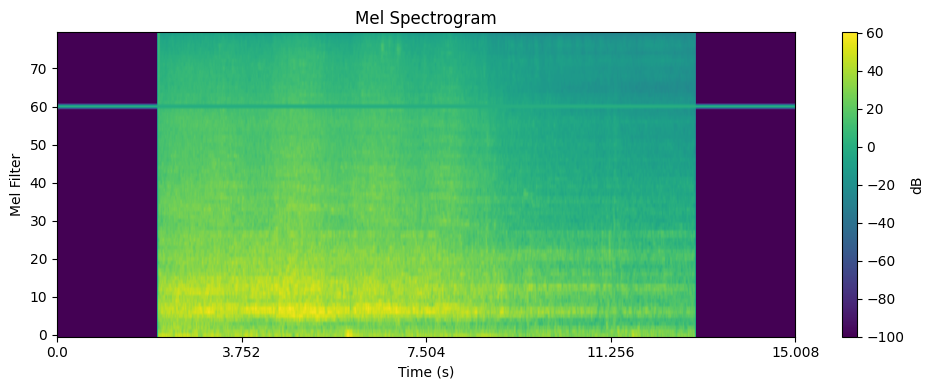

In [6]:
def plot_mel_spectrogram(melspe_db, sample_rate, hop_length):
    plt.figure(figsize=(10, 4))

    # Convert tensor data to numpy for visualization
    melspe_db_np = melspe_db.squeeze().cpu().numpy()

    # Display the spectrogram
    plt.imshow(melspe_db_np, cmap='viridis', origin='lower', aspect='auto')

    # Setting labels and title
    plt.ylabel('Mel Filter')
    plt.xlabel('Time (s)')
    plt.colorbar(label='dB')
    plt.title('Mel Spectrogram')

    # Adjust x-axis to show time in seconds
    num_time_bins = melspe_db_np.shape[1]
    plt.xticks(np.linspace(0, num_time_bins, 5), np.linspace(0, num_time_bins * hop_length / sample_rate, 5))

    plt.tight_layout()
    plt.show()

# Set the hop length (change this if you specified a different value when computing the spectrogram)
 # Default in torchaudio
plot_mel_spectrogram(melspe_db, sample_rate,hop_length)
